<a href="https://colab.research.google.com/github/limhyeona2000/2020-2-AI/blob/master/code/20191783-%EC%9E%84%ED%98%84%EC%95%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **회귀 문제: 당뇨병 발생 예측**

## **I. 개요**

당뇨병을 발생을 예측하는 회귀 분석으로 sklearn에서 제공하는 데이터셋인 diabetes를 사용하여 예측할 수 있는 모델을 만들어 보는 것이 목표이다.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_diabetes

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


## **Ⅱ. 데이터 저장과 전처리**

문제를 풀기 위해 필요한 환경을 구축해준다.
데이터 셋에 어떻게 데이터가 들어가 있는지 확인해줍니다. 데이터들의 이름을 알아 사용하기 위함이다.

In [2]:
diabetes = load_diabetes()
diabetes

{'DESCR': '.. _diabetes_dataset:\n\nDiabetes dataset\n----------------\n\nTen baseline variables, age, sex, body mass index, average blood\npressure, and six blood serum measurements were obtained for each of n =\n442 diabetes patients, as well as the response of interest, a\nquantitative measure of disease progression one year after baseline.\n\n**Data Set Characteristics:**\n\n  :Number of Instances: 442\n\n  :Number of Attributes: First 10 columns are numeric predictive values\n\n  :Target: Column 11 is a quantitative measure of disease progression one year after baseline\n\n  :Attribute Information:\n      - Age\n      - Sex\n      - Body mass index\n      - Average blood pressure\n      - S1\n      - S2\n      - S3\n      - S4\n      - S5\n      - S6\n\nNote: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).\n\nSource URL:\nhttps://www4.stat.ncsu.edu/~boos/var.select/

In [3]:
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df["target"] = diabetes.target
df.tail()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0
441,-0.045472,-0.044642,-0.073030,-0.081414,0.083740,0.027809,0.173816,-0.039493,-0.004220,0.003064,57.0


더 편안하게 확인하기 위함이다.

## **Ⅲ. 데이터 수, 속성 수 등 소개**

In [4]:
df.shape #데이터 양 확인

(442, 11)

In [5]:
type(df) #데이터 타입 확인

pandas.core.frame.DataFrame

In [6]:
df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0


## **Ⅳ. 훈련과 테스트 데이터 나누기**

훈련/테스트하기 위해 데이터 양을 확인해준다.

In [7]:
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)

print(train_df.shape, test_df.shape)

(354, 11) (88, 11)


age, bmi, bp, s1을 사용하여 확인하기론 bmi가 bp, si와 다중공신성 관계에 있는 것 같다.

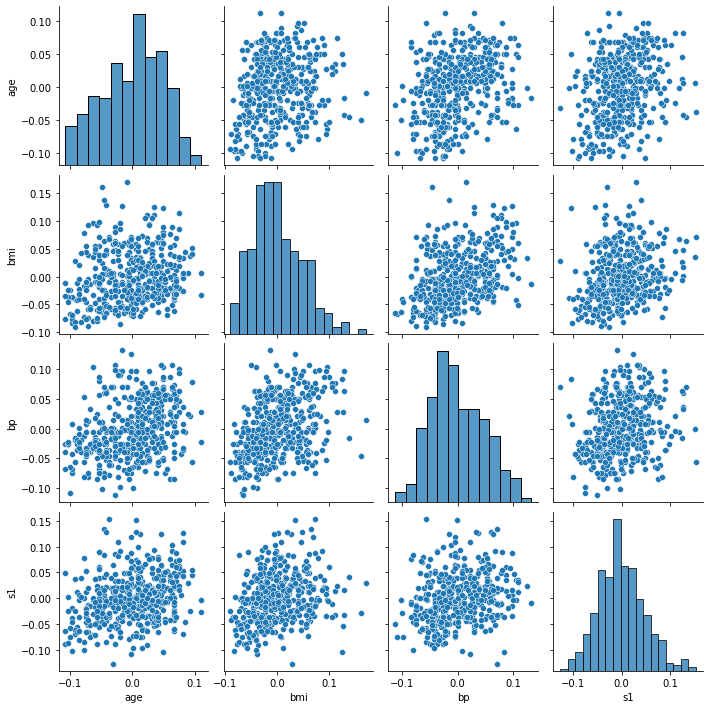

In [8]:
sns.pairplot(df[["age", "bmi", "bp", "s1"]])
plt.show()

bmi를 기준으로 문제를 풀어나갈 생각이다. 상태값들을 만들어준다.

In [9]:
train_stats = train_df.describe()
train_stats.pop("bmi")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
age,354.0,-0.000702,0.047152,-0.107226,-0.037299,0.005383,0.037168,0.110727
sex,354.0,-0.001289,0.047533,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bp,354.0,-0.000234,0.047266,-0.112400,-0.036656,-0.005671,0.035644,0.132044
s1,354.0,-0.000663,0.047865,-0.126781,-0.034592,-0.004321,0.026982,0.153914
s2,354.0,-0.000124,0.048652,-0.115613,-0.031141,-0.007420,0.030940,0.198788
s3,354.0,0.000919,0.048366,-0.098625,-0.032356,-0.006584,0.026550,0.181179
s4,354.0,-0.001514,0.046538,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,354.0,-0.001851,0.046333,-0.126097,-0.033249,-0.004683,0.031036,0.133599
s6,354.0,0.001379,0.046179,-0.129483,-0.030072,-0.001078,0.027917,0.135612
target,354.0,151.813559,75.691294,25.000000,87.250000,141.000000,206.000000,346.000000


In [10]:
train_labels = train_df.pop('bmi')
test_labels = test_df.pop('bmi')

bmi를 기준으로 모두 값을 구해준다.

In [11]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_df)
normed_test_data = norm(test_df)
normed_train_data.tail()

,age,sex,bp,s1,s2,s3,s4,s5,s6,target
207,0.206090,-0.912053,0.613385,0.268542,-0.281924,0.529944,-0.816092,1.035631,0.754061,0.663041
279,0.822402,1.093330,0.103500,-0.536354,-0.539384,0.301581,-0.816092,-0.305333,-0.591390,0.636618
227,1.438714,1.093330,1.220392,0.009826,-0.320543,1.519518,-1.053971,-0.790105,0.126184,-0.578845
148,-1.257650,1.093330,-0.406386,0.785976,0.992503,0.377702,-0.023161,-0.623745,-0.053210,-0.737384
143,-0.641339,-0.912053,-0.187863,0.412274,0.142885,1.519518,-0.816092,-0.848838,-0.950177,-1.213000


## **Ⅴ. 딥러닝 모델**

아까 구한 값을 통해 모델을 만들어준다.

In [12]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_df.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

모델을 summary()를 통해 값을 구해준다.

In [13]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


## **Ⅵ. 데이터와 훈련과정, 예측 결과의 시각화**

모델을 에포크를 통해 훈련시켜줍니다.

In [14]:
# 에포크가 끝날 때마다 점(.)을 출력, 100번마다 다음 줄로 이동해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, 
                    validation_split = 0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

모델의 손실값과 정확도를 구해줍니다.

In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.000017,0.003084,0.000017,0.002156,0.035363,0.002156,995
996,0.000030,0.004046,0.000030,0.002051,0.034202,0.002051,996
997,0.000022,0.003610,0.000022,0.002154,0.034802,0.002154,997
998,0.000014,0.002821,0.000014,0.002186,0.035205,0.002186,998
999,0.000037,0.004541,0.000037,0.002154,0.034409,0.002154,999


손실값과 정확도에 대한 그래프를 그려줌으로 훈련이 잘 되었는지 확인해준다.

## **Ⅶ. 정확도와 손실 그래프**

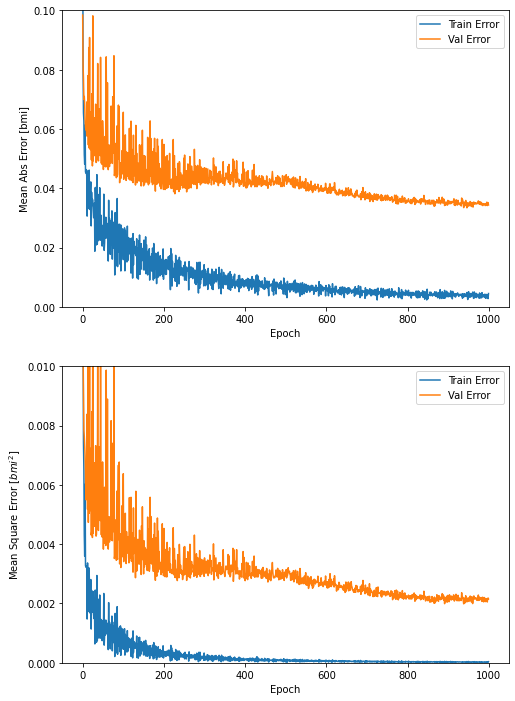

In [16]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [bmi]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,0.1])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$bmi^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,0.01])
    plt.legend()
    plt.show()

plot_history(history)

## **Ⅷ. 예측 결과**

평균 절대 오차가 매우 작은 것은 좋은 일이지만 정확도가 떨어지는 것을 볼 수 있다.

In [17]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} target".format(mae))

3/3 - 0s - loss: 0.0020 - mae: 0.0349 - mse: 0.0020
테스트 세트의 평균 절대 오차:  0.03 target


정확도와 손실값에 대한 그래프를 그려줌으로 모델이 잘 만들어졌는지 확인해준다.

0.14857185165809028
0.14297766499221326


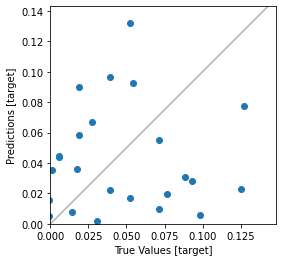

In [18]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [target]')
plt.ylabel('Predictions [target]')
plt.axis('equal') # 각 축의 범위와 축의 스케일을 동일하게 설정
plt.axis('square') # 각 축의 범위를 xmax - xmin = ymax - ymin 이 되도록 설정
print(plt.xlim()[1])
plt.xlim([0, plt.xlim()[1]])
print(plt.ylim()[1])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100], c='.7')

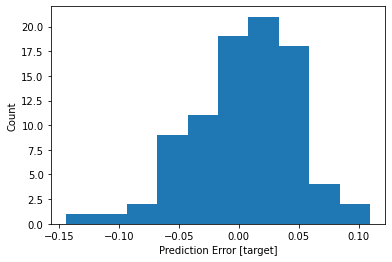

In [19]:
error = test_predictions - test_labels
plt.hist(error, bins = 10)
plt.xlabel("Prediction Error [target]")
_ = plt.ylabel("Count")

# **분류 문제: Iris 붓꽃 분류**

## **I. 개요**

붓꽃의 꽃잎petal과 꽃받침sepal의 폭과 길이를 센티미터 단위로 측정하여 setosa, versicolor, virginica 종으로 분류한 붓꽃의 측정 데이터를 이용해서 채집한 붓꽃이 어떤 품종인지 구분하는 것입니다.

 
class: 출력될 수 있는 값(붓꽃의 종류)들 (setosa, versicolor, virginica)

label: 데이터 포인트 하나(붓꽃 하나)에 대한 기대 출력은 꽃의 품종

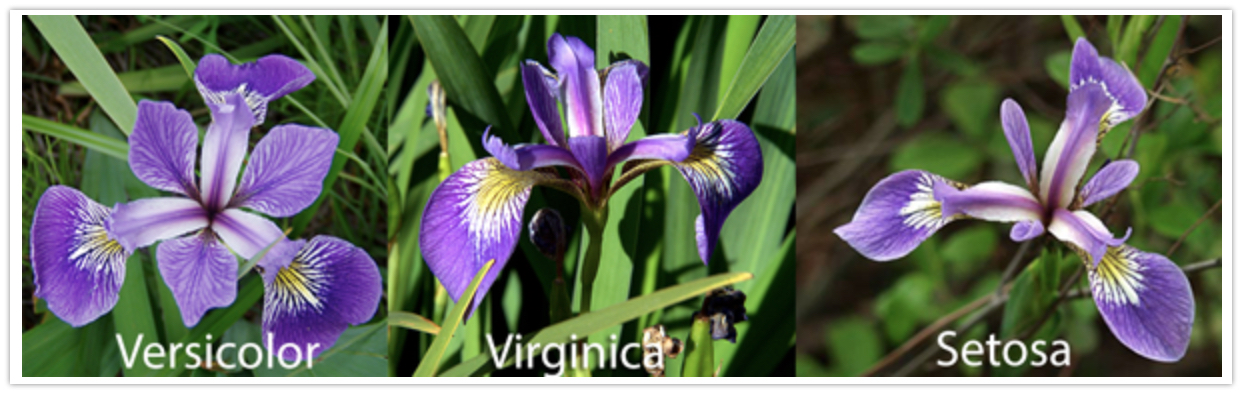

## **II. 데이터 불러오기 및 정규화**

먼저 문제를 풀기 위해 필요한 준비를 마치고 Iris 데이터 셋은 seaborn에 있는 데이터를 불러옵니다.

In [20]:
#Iris 붓꽃 데이터 불러오기

import tensorflow as tf
import seaborn as sns

sns.set(style="ticks", color_codes=True)
iris = sns.load_dataset("iris")

## **Ⅲ. 데이터 수, 속성 수 등 소개**

In [21]:
iris.info() #Iris 붓꽃 데이터 속성

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [22]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


불러온 데이터에 어떤 데이터가 들어있는지 확인합니다.

In [23]:
iris['species'].unique() #Iris 종의 종류

array(['setosa', 'versicolor', 'virginica'], dtype=object)

붓꽃을 분류하기 전 종류를 확인합니다. 종류가 세가지로 원핫인코딩 방식을 사용하여 종류를 나누어 데이터를 분류해둡니다.

In [24]:
#종별로 원핫인코딩 방식을 사용하여 분류

from sklearn.preprocessing import LabelEncoder
import pandas as pd

X = iris.iloc[:,0:4].values
y = iris.iloc[:,4].values

encoder =  LabelEncoder()
y1 = encoder.fit_transform(y)
Y = pd.get_dummies(y1).values
Y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

## **Ⅳ. 훈련과 테스트 데이터 나누기**

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1) 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120, 3), (30, 3))

훈련/테스트 데이터를 나눕니다.

## **Ⅴ. 딥러닝 모델**

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

model = Sequential()

model.add(Dense(64,input_shape=(4,),activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(3,activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 4,675
Trainable params: 4,675
Non-trainable params: 0
_________________________________________________________________


딥러닝 모델을 최적화해줍니다.

## **Ⅵ. 데이터와 훈련과정, 예측 결과의 시각화**

최적화한 데이터를 100번 훈련을 통해 훈련시켜줍니다.

In [27]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
4/4 [==============================] - 0s 36ms/step - loss: 1.3000 - accuracy: 0.3083 - val_loss: 1.0560 - val_accuracy: 0.4333
Epoch 2/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0767 - accuracy: 0.3167 - val_loss: 1.0403 - val_accuracy: 0.2000
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9714 - accuracy: 0.4083 - val_loss: 1.0358 - val_accuracy: 0.4333
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9135 - accuracy: 0.6583 - val_loss: 0.9843 - val_accuracy: 0.5667
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.8551 - accuracy: 0.6917 - val_loss: 0.9135 - val_accuracy: 0.5667
Epoch 6/100
4/4 [==============================] - 0s 6ms/step - loss: 0.7976 - accuracy: 0.6917 - val_loss: 0.8294 - val_accuracy: 0.5667
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7551 - accuracy: 0.7500 - val_loss: 0.7612 - val_accuracy: 0.7000
Epoch 8/100
4/4 [=========

## **Ⅶ. 정확도와 손실 그래프**

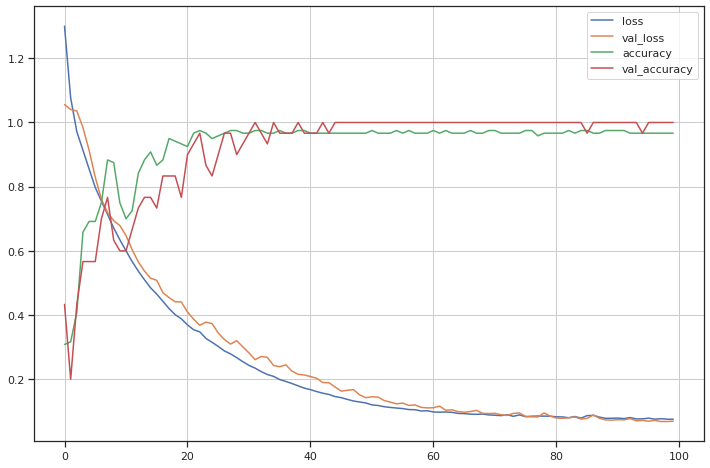

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.grid()
plt.show()

## **Ⅷ. 예측 결과**

In [29]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy = {:.2f}".format(accuracy))

1/1 [==============================] - 0s 1ms/step - loss: 0.0693 - accuracy: 1.0000
Accuracy = 1.00


검증 데이터에서 loss 는 꾸준히 감소하는 것을 볼 수 있으며 정확도는 올라가는 것을 확인할 수 있습니다. 훈련 데이터를 잘 훈련하였다는 것을 알 수 있습니다.

마지막으로 잘 훈련했는지 알기 위해 모델을 평가해줍니다. 정확도가 1로 나왔으며 손실은 0.0007로 매우 잘 훈련한 것을 확인할 수 있습니다.

# **CNN 문제: CIFAR-10 분류(반드시 CNN 사용해 딥러닝 처리)**

## **I. 개요**

    네트워크 구조와 학습 및 평가의 표준적인 구성에 주목하고,더 크고 복잡한 모델에 대한 예제를 제공합니다.

CIFAR-10 분류는 기계학습에서 흔히 사용되는 벤치마크 문제입니다. 이 분류 문제는 RGB 32x32 픽셀 이미지(비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭 등)를 다음의 10개 카테고리로 분류하는 것이 목표입니다

## **Ⅱ. 데이터 불러오기 및 정규화**

In [30]:
    # 사용할 라이브러리 불러오기
    import numpy as np
    # 숫자 -> One-hot Vector 를 위한 라이브러리
    from keras.utils import np_utils
    # CIFAR-10 Dataset을 가져오기 위한 라이브러리
    from keras.datasets import cifar10
    # 순차적인 모델을 만들기 위한 Sequential 함수
    from keras.models import Sequential
    # 필요한 층들을 가지고 있는 layers 라이브러리
    from keras.layers import Dense, Activation
    from keras.layers import Conv2D, MaxPooling2D, Flatten
    # Google Colab에서 이미지를 보기 위한 cv2_imshow 함수
    from google.colab.patches import cv2_imshow

케라스에서 cifiar-10 데이터를 가져와줍니다.

In [31]:
    # CIFAR-10 Dataset 가져오기
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    print('x_train :', np.shape(x_train))
    print('y_train :', np.shape(y_train))
    print('x_test :', np.shape(x_test))
    print('y_test :', np.shape(y_test))

170500096/170498071 [==============================] - 2s 0us/step
x_train : (50000, 32, 32, 3)
y_train : (50000, 1)
x_test : (10000, 32, 32, 3)
y_test : (10000, 1)


훈련/테스트 데이터가 어느 정도 있는지 확인해줍니다.
훈련 데이터 내에 어떤 데이터가 들어있는지 확인합니다.

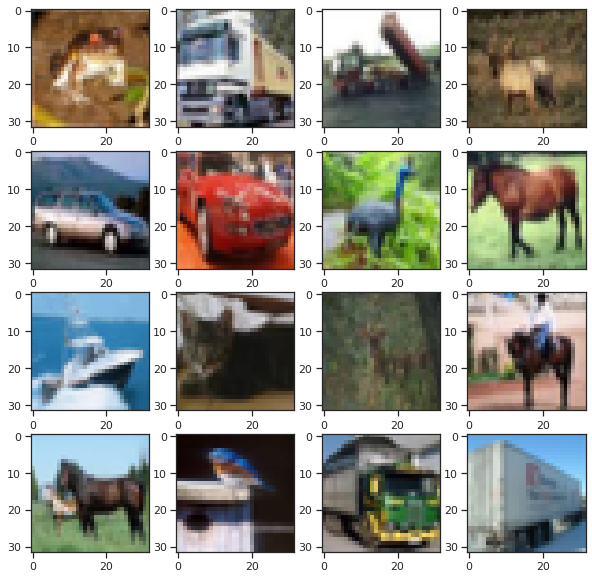

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]
 [4]
 [7]
 [7]
 [2]
 [9]
 [9]]


In [32]:
import matplotlib.pyplot as plt

# 전체 그래프의 크기를 width = 10, height = 10으로 지정합니다. 
plt.figure(figsize=(10, 10))
for c in range(16): 
  # 4행 4열로 지정한 그리드에서 c+1번째의 칸에 그래프를 그립니다. 1~16번째 칸을 채우게 됩니다. 
  plt.subplot(4,4,c+1)
  plt.imshow(x_train[c])

plt.show()

# 훈련 데이터이 1~16번째 까지의 라벨 프린트합니다. 
print(y_train[:16])

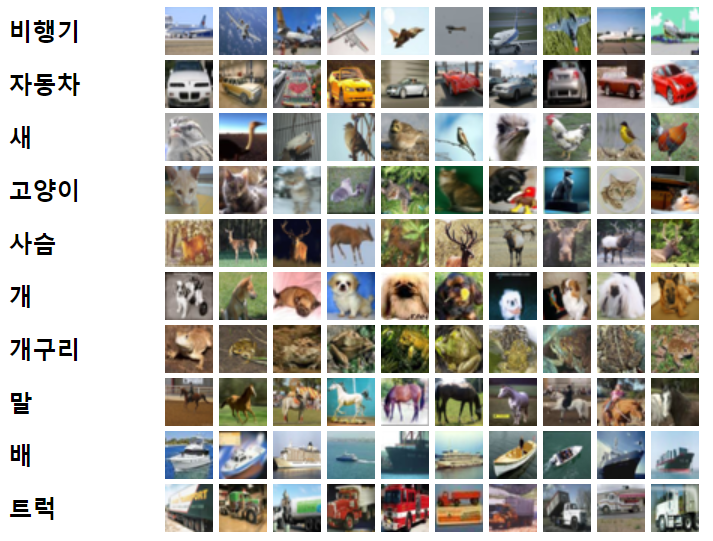

위에서 출력한 것과 같이 cifia-10 분류로는 위 그림과 같은 그림들로 분류되는 것을 확인할 수 있습니다.
하단처럼 CNN 모델에 맞게 데이터셋을 바꿔줍니다.

In [33]:
    # Loss의 스케일 조정을 위해 0 ~ 255 -> 0 ~ 1 범위로 만들어줍니다
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    # 이번엔 Test Dataset을 Validation Set으로 써봅니다
    # One-Hot Encoding (숫자 -> One-Hot Vector) 
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    print('y_train :', np.shape(y_train))

y_train : (50000, 10)


## **Ⅲ. 딥러닝 모델 생성**

   ### (1) 컨볼루션 신경망 모델 정의

In [34]:
    # 모델 구성하기
    # 높이, 너비, 채널(RGB) 설정
    width = 32
    height = 32
    channel = 3
    # 순차적 모델을 만들기 위한 Sequential() 함수
    model = Sequential(name='CIFAR10_CNN')
    # filters : Kernel 그룹의 갯수 / kernel_size : Kernel 크기
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=(width, height, channel)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    # pool_size : MaxPooling 의 Window size
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # N차원 배열을 1차원으로 펴줍니다
    model.add(Flatten())
    # 출력층 MLP
    model.add(Dense(10, activation='softmax'))
    model.summary()

Model: "CIFAR10_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         

   ### (2) 컨볼루션 신경망 모델 학습

학습을 통해 정확도를 높이기 때문에 중요한 부분이다. 목적 함수를 분류가 2개 이상인 CEE로 지정해두고 학습 방법은 SGD를 사용합니다.

In [35]:
    # 모델 학습과정 설정하기
    # loss : 목적 함수
    # categorical_crossentropy : 분류가 2개 이상인 CEE
    # optimizer : 학습 방법, SGD를 사용합니다.
    # metrics : 학습 도중 화면에 어떤 값을 띄울까를 결정합니다.
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    # 모델 학습시키기
    # hist는 Epoch 당 학습 결과를 갖게 됩니다.
    hist = model.fit(x_train, y_train,
                     epochs=30,
                     batch_size=32,
                     validation_data=(x_test, y_test))

Epoch 1/30
1563/1563 [==============================] - 8s 5ms/step - loss: 2.0792 - accuracy: 0.2434 - val_loss: 1.8424 - val_accuracy: 0.3459
Epoch 2/30
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6257 - accuracy: 0.4217 - val_loss: 1.4575 - val_accuracy: 0.4816
Epoch 3/30
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4180 - accuracy: 0.4970 - val_loss: 1.3835 - val_accuracy: 0.5127
Epoch 4/30
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2875 - accuracy: 0.5457 - val_loss: 1.2590 - val_accuracy: 0.5569
Epoch 5/30
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1804 - accuracy: 0.5866 - val_loss: 1.2395 - val_accuracy: 0.5684
Epoch 6/30
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0879 - accuracy: 0.6178 - val_loss: 1.1974 - val_accuracy: 0.5750
Epoch 7/30
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0027 - accuracy: 0.6496 - val_loss: 1.0771 - val_accuracy:

## **Ⅴ. 예측 결과**

In [36]:
    #모델 평가
    loss_and_acc = model.evaluate(x_test, y_test, batch_size=32)
    print('Test set Loss and Accuracy')
    print(loss_and_acc)

313/313 [==============================] - 1s 3ms/step - loss: 2.0229 - accuracy: 0.6703
Test set Loss and Accuracy
[2.0229434967041016, 0.6703000068664551]


학습한 모델을 평가합니다. 손실이 낮을 수록 좋고, 정확도가 높을수록 좋습니다. 현재 모델 평가가 높게 나온 것을 확인할 수 있습니다.

마지막으로 모델을 잘 예측하는지 확인해봅니다.

: 고양이 / 정답: 고양이


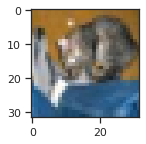

: 배 / 정답: 배


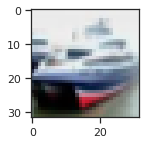

: 비행기 / 정답: 배


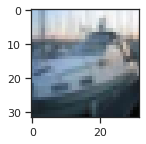

: 비행기 / 정답: 비행기


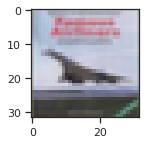

: 사슴 / 정답: 개구리


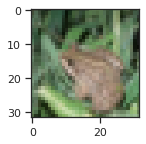

: 개구리 / 정답: 개구리


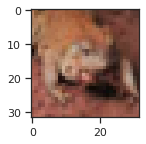

: 자동차 / 정답: 자동차


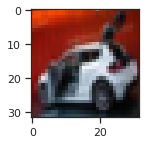

: 개구리 / 정답: 개구리


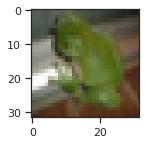

: 고양이 / 정답: 고양이


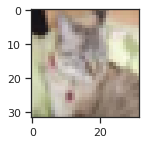

: 자동차 / 정답: 자동차


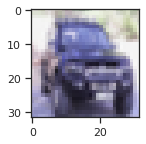

In [37]:
    #모델 사용하기
    # 이미지의 종류가 무엇인지에 대한 리스트
    labels = ['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말', '배', '트럭']
    # 출력 그림의 크기를 결정합니다.
    plt.rcParams["figure.figsize"] = (2,2)
    # Test Set의 10개를 맞추어 봅시다.
    for i in range(10):
      # 모델 사용 
      output = model.predict(x_test[i].reshape(1,width, height, channel))
      
      # 이미지 출력 
      plt.imshow(x_test[i].reshape(width, height, channel))
      # np.argmax()가 labels의 인덱스가 되어 labels 배열에 있는 문자열을 출력합니다.
      print(': ' + labels[np.argmax(output)] + ' / 정답: ' + labels[np.argmax(y_test[i])])
      plt.show()